## Compressed Image Recovery
This homework makes heavy use of the CVX package for convex optimization so make sure you have the appropriate Python or MATLAB variants installed for your programming language of choice.

The problem we consider is that of recovering an image from limited observations of its pixels. For example, consider a portion of René Magritte’s “The Son of Man” along with its corrupted variant. Our goal is to recover the original image from the corrupted version.

In [160]:
# Packages you will need 

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import skimage as ski

import skimage.io
import skimage.transform

import scipy.fftpack as spfft # for discrete cosine transform 

In [161]:
import cvxopt

In [195]:
# Image Compression using DCT on “The Son of Man”
# a. Load image. Downsample to 53x41 pixels and convert to grayscale
#    i. You can use built in functions from scikit image, ndimage, or cv2
#    ii. You should include what this downsampled/grayscale image looks like in 
#       your report since you will be assessing the quality of low dimensional
#       reconstructions compared to this original.

img_path = 'SonOfMan.png'

# read image
img_og = ski.io.imread(img_path)

# convert to grayscale and visualize 
img_og = ski.color.rgb2gray(img_og) #convert to gray scale

# fig, ax = plt.subplots(1, 2, figsize=(20,10))
# ax[0].imshow(img_og, cmap = 'gray')
# ax[0].set_title("Original image")

print("Original size: ", img_og.shape)

# resize image 
# img = ski.transform.rescale( img_og, 0.18, anti_aliasing=False) # downsampled to 53x41 pixels

print("Rescaled size: ", img.shape)

# ax[1].imshow(img, cmap='gray')
# ax[1].set_title("Rescaled image")

Original size:  (292, 228)
Rescaled size:  (53, 41)


<ipython-input-195-84c1ea122979>:14: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img_og = ski.color.rgb2gray(img_og) #convert to gray scale


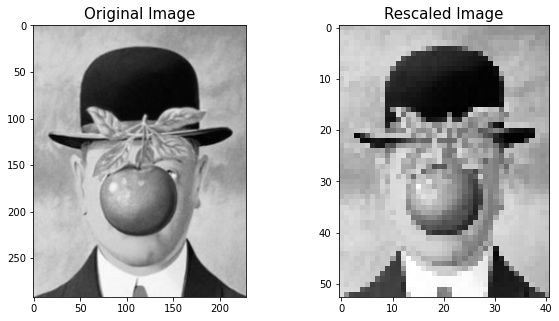

In [192]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1); plt.title('Original Image',fontsize=15)
plt.imshow(img_og,cmap='gray')

plt.subplot(1, 2, 2); plt.title('Rescaled Image',fontsize=15)
plt.imshow(img,cmap='gray')
fig.savefig('Fig1.pdf', dpi=fig.dpi)
plt.show()

#### Task 1 (Image Compression)


In [163]:
# ---------------------------------------------- construct forward and inverse DCT matrices from Helper code
def construct_DCT_Mat( Nx, Ny ):                  # construct DCT matrix
# input : Nx number of columns of image 
#         Ny number of rows of image 
# output: D DCT matrix mapping image.flatten() to 
#         DCT(image).flatten()
    Dx = spfft.dct(np.eye(Nx), axis =0, norm='ortho')
    Dy = spfft.dct(np.eye(Ny), axis = 0, norm='ortho')
    D = np.kron(Dy, Dx)
    return D

def construct_iDCT_Mat( Nx, Ny ):                # construct inverse DCT matrix
# input : Nx number of columns of image 
#         Ny number of rows of image 
# output: iD iDCT matrix mapping DCT(image).flatten() to 
#         image.flatten()
    Dx = spfft.idct(np.eye(Nx), axis =0, norm='ortho')
    Dy = spfft.idct(np.eye(Ny), axis = 0, norm = 'ortho')
    D = np.kron(Dy, Dx)
    return D

Let 𝑁𝑦 , 𝑁𝑥 denote the number of rows and columns of the image with 𝑁 = 𝑁𝑦 × 𝑁𝑥 denoting the number of pixels in the image. Let 𝐹 ∈ R𝑁𝑦×𝑁𝑥 denote the image and write vec(𝐹) ∈ R𝑁 for its vectorization, i.e., pixel values stacked into a long vector akin to Numpy’s flatten function. Use the functions construct_DCT_Mat and construct_iDCT_Mat to construct the forward and inverse DCT matrices for the image.

In [164]:
vecF = img.flatten() # Vectorize image using im_gray.flatten()

In [165]:
Nx = img.shape[0]
Ny = img.shape[1]

In [174]:
print(Nx)

53


In [317]:
D = construct_DCT_Mat(Nx,Ny) # Construct D using function construct_D_mat() provided in helper code
iD = construct_iDCT_Mat(Nx, Ny)

In [167]:
DCT_F = np.dot(D, vecF) # Matrix-vector multiply D and vectorized version of image to get DCT. Remember to use np.dot() or @, not just *

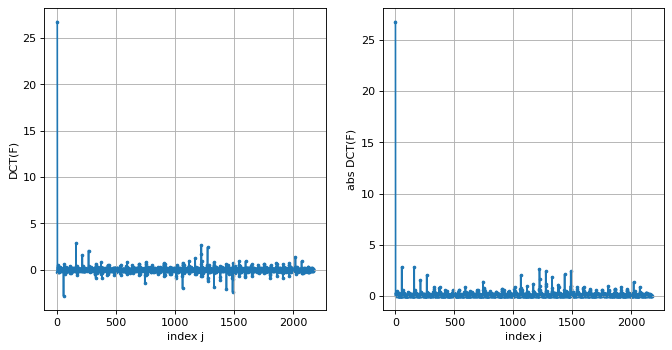

In [193]:
fig = plt.figure(figsize=(10, 5), dpi=80)

plt.subplot(1, 2, 1)

plt.scatter(np.arange(0,len(DCT_F)),DCT_F, s=5)
plt.plot(DCT_F)
plt.xlabel('index j'); plt.ylabel('DCT(F)'); plt.grid()

plt.subplot(1, 2, 2)

plt.scatter(np.arange(0,len(DCT_F)),np.abs(DCT_F), s=5)
plt.plot(np.abs(DCT_F))
plt.xlabel('index j')
plt.ylabel('abs DCT(F)')
plt.grid()
fig.savefig('Fig2.pdf', dpi=fig.dpi)

plt.show()

In [183]:
def threshold_DCT(array, percent_to_keep): # sourced from Discord member Jason
    DCT_F_threshold = np.copy(array)
    
    cutoff = np.percentile(DCT_F_threshold, 100-percent_to_keep)
    
    for i in range(len(DCT_F_threshold)):
        if np.abs(DCT_F_threshold[i]) < cutoff:
            DCT_F_threshold[i] = 0
    
    vec_F = np.dot(iD, DCT_F_threshold)
    img_threshold= np.reshape(vec_F, (Nx, Ny))
    
    return img_threshold

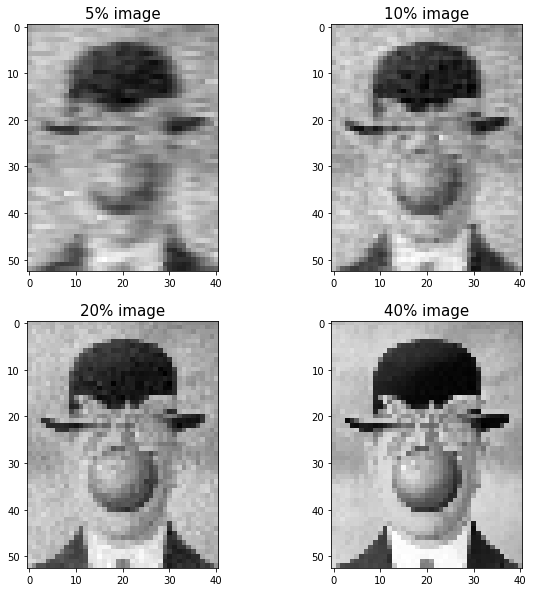

In [194]:
fig = plt.figure(figsize=(10,10))

plt.subplot(2, 2, 1); plt.title('5% image',fontsize=15)
plt.imshow(threshold_DCT(DCT_F, 5),cmap='gray')

plt.subplot(2, 2, 2); plt.title('10% image',fontsize=15)
plt.imshow(threshold_DCT(DCT_F, 10),cmap='gray')

plt.subplot(2, 2, 3); plt.title('20% image',fontsize=15)
plt.imshow(threshold_DCT(DCT_F, 20),cmap='gray')

plt.subplot(2, 2, 4); plt.title('40% image',fontsize=15)
plt.imshow(threshold_DCT(DCT_F, 40),cmap='gray')

fig.savefig('Fig3.pdf', dpi=fig.dpi)

plt.show()

#### Task 2 (Compressed Image Recovery)

In [324]:
def compressed_image_recovery( N, r ): 
    M = int(r*N) #  M is the number of points measured 

    I = np.identity(N)
    randomI = np.random.permutation(I)
    B = randomI[:M,:]

    y = np.dot(B, vecF)
    A = np.dot(B, iD)

    x = cvx.Variable(N)

    objective_l1 = cvx.Minimize( cvx.norm(x, 1))
    constraints_dct = [A*x == y]

    problem_dct = cvx.Problem( objective_l1, constraints_dct)
    x_star = problem_dct.solve(verbose=True, solver = 'CVXOPT', max_iter= 1000, reltol=1e-2, featol = 1e-2)

    recovery = np.dot(iD, x.value).reshape((53,41))
    return recovery

In [327]:
reshaped_image_reconstruction_06_1 = compressed_image_recovery( 2173, 0.6)
reshaped_image_reconstruction_06_2 = compressed_image_recovery( 2173, 0.6)
reshaped_image_reconstruction_06_3 = compressed_image_recovery( 2173, 0.6)

reshaped_image_reconstruction_04_1 = compressed_image_recovery( 2173, 0.4)
reshaped_image_reconstruction_04_2 = compressed_image_recovery( 2173, 0.4)
reshaped_image_reconstruction_04_3 = compressed_image_recovery( 2173, 0.4)

reshaped_image_reconstruction_02_1 = compressed_image_recovery( 2173, 0.2)
reshaped_image_reconstruction_02_2 = compressed_image_recovery( 2173, 0.2)
reshaped_image_reconstruction_02_3 = compressed_image_recovery( 2173, 0.2)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 16 02:52:09 PM: Your problem has 2173 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 16 02:52:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 16 02:52:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 16 02:52:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 16 02:52:09 PM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 16 02:52:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

/Users/cassiacai/opt/anaconda3/envs/firstEnv/lib/python3.8/site-packages/cvxpy/expressions/expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 5 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Mar 16 02:52:10 PM: Applying reduction CVXOPT
(CVXPY) Mar 16 02:52:10 PM: Finished problem compilation (took 1.079e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Mar 16 02:52:10 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0: -5.8748e-14 -2.2624e-15  4e+04  1e+03  7e-16  1e+00
 1:  3.2872e+01  3.3490e+01  1e+04  4e+02  3e-16  1e+00
 2:  5.5294e+01  5.5399e+01  2e+03  6e+01  3e-16  2e-01
 3:  1.2774e+02  1.2778e+02  6e+02  2e+01  5e-16  6e-02
 4:  1.9445e+02  1.9446e+02  2e+02  5e+00  8e-16  2e-02
 5:  2.2488e+02  2.2488e+02  6e+01  2e+00  1e-15  7e-03
 6:  2.3568e+02  2.3568e+02  2e+01  7e-01  1e-15  3e-03
 7:  2.3957e+02  2.3957e+02  9e+00  3e-01  1e-15  2e-03
 8:  2.4107e+02  2.4107e+02  3e+00  1e-01  1e-1

/Users/cassiacai/opt/anaconda3/envs/firstEnv/lib/python3.8/site-packages/cvxpy/expressions/expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 6 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Mar 16 02:53:48 PM: Applying reduction CVXOPT
(CVXPY) Mar 16 02:53:48 PM: Finished problem compilation (took 1.054e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Mar 16 02:53:48 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.0099e-13 -3.9726e-15  4e+04  1e+03  7e-16  1e+00
 1:  3.2815e+01  3.3435e+01  1e+04  4e+02  4e-16  1e+00
 2:  5.4883e+01  5.4990e+01  2e+03  6e+01  3e-16  2e-01
 3:  1.2501e+02  1.2506e+02  6e+02  2e+01  6e-16  6e-02
 4:  1.8962e+02  1.8964e+02  2e+02  6e+00  7e-16  2e-02
 5:  2.1901e+02  2.1902e+02  8e+01  2e+00  1e-15  1e-02
 6:  2.3249e+02  2.3250e+02  3e+01  8e-01  1e-15  5e-03
 7:  2.3687e+02  2.3687e+02  1e+01  3e-01  1e-15  2e-03
 8:  2.3864e+02  2.3865e+02  5e+00  2e-01  1e-1

/Users/cassiacai/opt/anaconda3/envs/firstEnv/lib/python3.8/site-packages/cvxpy/expressions/expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 7 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Mar 16 02:55:19 PM: Applying reduction CVXOPT
(CVXPY) Mar 16 02:55:20 PM: Finished problem compilation (took 1.007e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Mar 16 02:55:20 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0: -8.4058e-14  4.6475e-15  4e+04  1e+03  7e-16  1e+00
 1:  3.2799e+01  3.3410e+01  1e+04  4e+02  3e-16  1e+00
 2:  5.5796e+01  5.5901e+01  2e+03  6e+01  3e-16  2e-01
 3:  1.3149e+02  1.3153e+02  6e+02  2e+01  5e-16  5e-02
 4:  2.0023e+02  2.0025e+02  2e+02  5e+00  9e-16  2e-02
 5:  2.2827e+02  2.2828e+02  6e+01  2e+00  1e-15  8e-03
 6:  2.4027e+02  2.4027e+02  2e+01  7e-01  1e-15  3e-03
 7:  2.4388e+02  2.4388e+02  1e+01  3e-01  1e-15  2e-03
 8:  2.4570e+02  2.4570e+02  4e+00  1e-01  1e-1

/Users/cassiacai/opt/anaconda3/envs/firstEnv/lib/python3.8/site-packages/cvxpy/expressions/expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 8 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Mar 16 02:56:51 PM: Applying reduction CVXOPT
(CVXPY) Mar 16 02:56:51 PM: Finished problem compilation (took 6.869e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Mar 16 02:56:51 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0: -7.2591e-14  4.4325e-14  3e+04  8e+02  5e-16  1e+00
 1:  3.2068e+01  3.2414e+01  1e+04  3e+02  3e-16  8e-01
 2:  5.1209e+01  5.1393e+01  1e+03  4e+01  4e-16  2e-01
 3:  1.1135e+02  1.1144e+02  6e+02  2e+01  5e-16  1e-01
 4:  1.5957e+02  1.5960e+02  2e+02  7e+00  7e-16  4e-02
 5:  1.8416e+02  1.8418e+02  9e+01  3e+00  7e-16  2e-02
 6:  1.9412e+02  1.9413e+02  4e+01  1e+00  8e-16  7e-03
 7:  1.9776e+02  1.9776e+02  1e+01  5e-01  8e-16  3e-03
 8:  1.9960e+02  1.9960e+02  6e+00  2e-01  1e-1

/Users/cassiacai/opt/anaconda3/envs/firstEnv/lib/python3.8/site-packages/cvxpy/expressions/expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 9 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Mar 16 02:58:06 PM: Applying reduction CVXOPT
(CVXPY) Mar 16 02:58:06 PM: Finished problem compilation (took 6.876e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Mar 16 02:58:06 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0: -7.8739e-14  5.5026e-14  3e+04  8e+02  5e-16  1e+00
 1:  3.2100e+01  3.2445e+01  1e+04  3e+02  3e-16  8e-01
 2:  5.1395e+01  5.1581e+01  2e+03  5e+01  4e-16  2e-01
 3:  1.0906e+02  1.0914e+02  6e+02  2e+01  4e-16  1e-01
 4:  1.5795e+02  1.5799e+02  2e+02  7e+00  7e-16  4e-02
 5:  1.8756e+02  1.8757e+02  8e+01  2e+00  8e-16  1e-02
 6:  1.9695e+02  1.9695e+02  3e+01  9e-01  9e-16  6e-03
 7:  2.0020e+02  2.0020e+02  1e+01  4e-01  9e-16  3e-03
 8:  2.0173e+02  2.0173e+02  6e+00  2e-01  9e-1

/Users/cassiacai/opt/anaconda3/envs/firstEnv/lib/python3.8/site-packages/cvxpy/expressions/expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 10 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Mar 16 02:59:17 PM: Applying reduction CVXOPT
(CVXPY) Mar 16 02:59:17 PM: Finished problem compilation (took 6.796e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Mar 16 02:59:17 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0: -6.1399e-14  3.8810e-14  3e+04  8e+02  5e-16  1e+00
 1:  3.2337e+01  3.2685e+01  1e+04  3e+02  3e-16  8e-01
 2:  5.1996e+01  5.2180e+01  1e+03  4e+01  2e-16  2e-01
 3:  1.1453e+02  1.1460e+02  6e+02  2e+01  4e-16  1e-01
 4:  1.6498e+02  1.6501e+02  2e+02  6e+00  6e-16  4e-02
 5:  1.8460e+02  1.8461e+02  9e+01  3e+00  7e-16  2e-02
 6:  1.9499e+02  1.9500e+02  4e+01  1e+00  8e-16  8e-03
 7:  1.9975e+02  1.9976e+02  2e+01  5e-01  9e-16  3e-03
 8:  2.0161e+02  2.0161e+02  7e+00  2e-01  9e-1

/Users/cassiacai/opt/anaconda3/envs/firstEnv/lib/python3.8/site-packages/cvxpy/expressions/expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 11 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Mar 16 03:00:28 PM: Applying reduction CVXOPT
(CVXPY) Mar 16 03:00:28 PM: Finished problem compilation (took 3.322e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Mar 16 03:00:28 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.1154e-14  2.9259e-14  1e+04  4e+02  4e-16  1e+00
 1:  3.2046e+01  3.2177e+01  6e+03  2e+02  2e-16  6e-01
 2:  4.7487e+01  4.7817e+01  2e+03  6e+01  4e-16  5e-01
 3:  8.1998e+01  8.2110e+01  7e+02  2e+01  4e-16  2e-01
 4:  1.1326e+02  1.1332e+02  4e+02  1e+01  6e-16  8e-02
 5:  1.3316e+02  1.3318e+02  1e+02  4e+00  6e-16  3e-02
 6:  1.4177e+02  1.4178e+02  6e+01  2e+00  5e-16  1e-02
 7:  1.4523e+02  1.4524e+02  3e+01  8e-01  6e-16  6e-03
 8:  1.4693e+02  1.4693e+02  1e+01  3e-01  6e-1

/Users/cassiacai/opt/anaconda3/envs/firstEnv/lib/python3.8/site-packages/cvxpy/expressions/expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 12 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Mar 16 03:01:20 PM: Applying reduction CVXOPT
(CVXPY) Mar 16 03:01:20 PM: Finished problem compilation (took 3.355e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Mar 16 03:01:20 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  9.0761e-15  2.2830e-14  1e+04  4e+02  4e-16  1e+00
 1:  3.1640e+01  3.1772e+01  6e+03  2e+02  2e-16  6e-01
 2:  4.5501e+01  4.5832e+01  2e+03  6e+01  4e-16  5e-01
 3:  7.6641e+01  7.6759e+01  7e+02  2e+01  5e-16  2e-01
 4:  1.0947e+02  1.0952e+02  3e+02  1e+01  5e-16  7e-02
 5:  1.2750e+02  1.2753e+02  2e+02  5e+00  5e-16  3e-02
 6:  1.3618e+02  1.3619e+02  7e+01  2e+00  7e-16  2e-02
 7:  1.3977e+02  1.3978e+02  3e+01  9e-01  5e-16  7e-03
 8:  1.4153e+02  1.4154e+02  1e+01  4e-01  6e-1

/Users/cassiacai/opt/anaconda3/envs/firstEnv/lib/python3.8/site-packages/cvxpy/expressions/expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 13 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Mar 16 03:02:11 PM: Applying reduction CVXOPT
(CVXPY) Mar 16 03:02:11 PM: Finished problem compilation (took 3.193e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Mar 16 03:02:11 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.5354e-15  2.4575e-14  1e+04  4e+02  4e-16  1e+00
 1:  3.1827e+01  3.1962e+01  6e+03  2e+02  2e-16  6e-01
 2:  4.4970e+01  4.5309e+01  2e+03  6e+01  2e-16  5e-01
 3:  7.5172e+01  7.5292e+01  8e+02  2e+01  3e-16  2e-01
 4:  1.0232e+02  1.0238e+02  4e+02  1e+01  4e-16  9e-02
 5:  1.2381e+02  1.2383e+02  2e+02  5e+00  6e-16  3e-02
 6:  1.3304e+02  1.3305e+02  7e+01  2e+00  6e-16  2e-02
 7:  1.3701e+02  1.3701e+02  3e+01  9e-01  6e-16  7e-03
 8:  1.3865e+02  1.3865e+02  1e+01  4e-01  6e-1

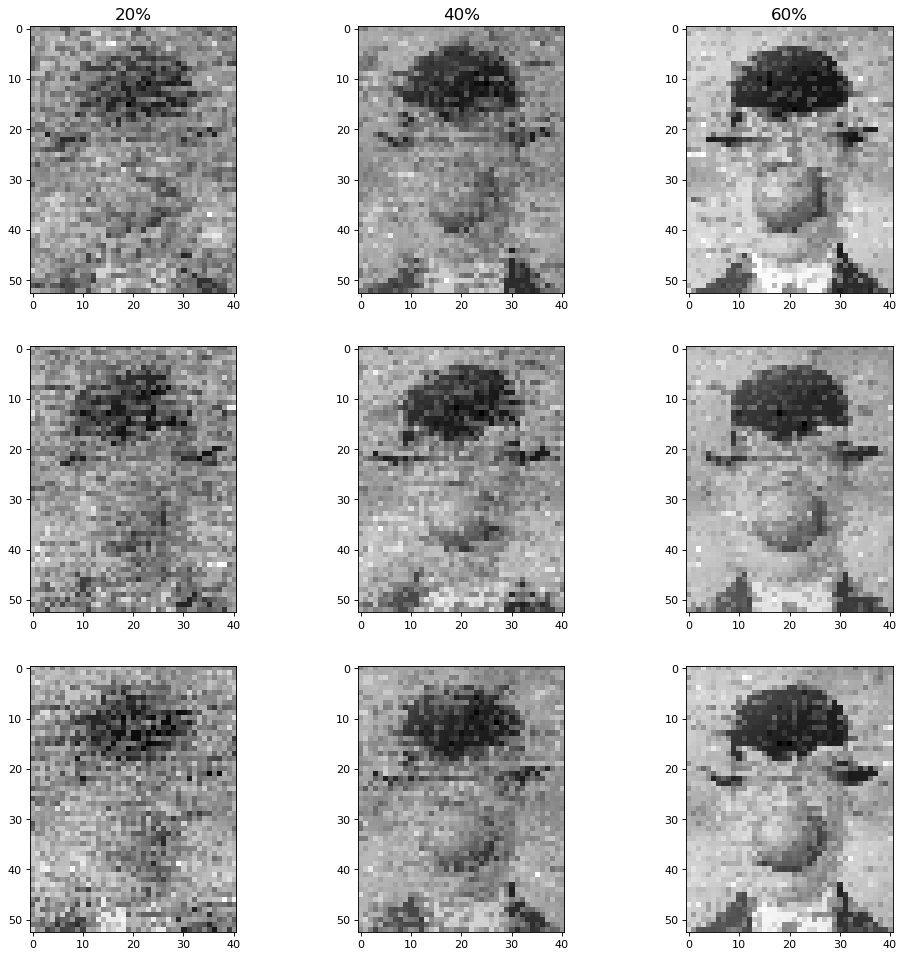

In [331]:
fig = plt.figure(figsize=(15, 15), dpi=80)

plt.subplot(3, 3, 1)
plt.title('20%',fontsize=15)
plt.imshow(reshaped_image_reconstruction_02_1,cmap='gray')

plt.subplot(3, 3, 4)
plt.imshow(reshaped_image_reconstruction_02_2,cmap='gray')

plt.subplot(3, 3, 7)
plt.imshow(reshaped_image_reconstruction_02_3,cmap='gray')

plt.subplot(3, 3, 2)
plt.title('40%',fontsize=15)
plt.imshow(reshaped_image_reconstruction_04_1,cmap='gray')

plt.subplot(3, 3, 5)
plt.imshow(reshaped_image_reconstruction_04_2,cmap='gray')

plt.subplot(3, 3, 8)
plt.imshow(reshaped_image_reconstruction_04_3,cmap='gray')

plt.subplot(3, 3, 3)
plt.title('60%',fontsize=15)
plt.imshow(reshaped_image_reconstruction_06_1,cmap='gray')

plt.subplot(3, 3, 6)
plt.imshow(reshaped_image_reconstruction_06_2,cmap='gray')

plt.subplot(3, 3, 9)
plt.imshow(reshaped_image_reconstruction_06_3,cmap='gray')

fig.savefig('Fig4.pdf', dpi=fig.dpi)
plt.show()

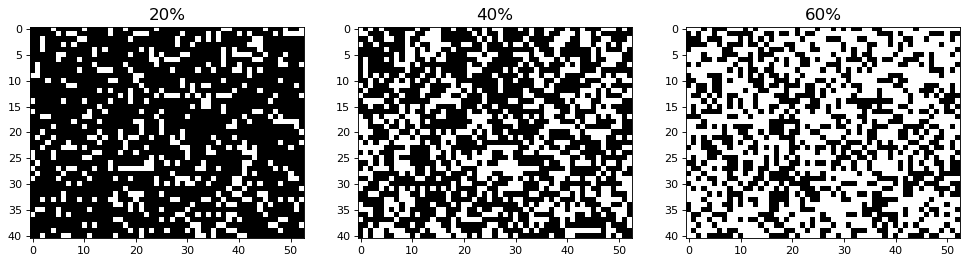

In [337]:
# Let M<N be an integer and construct a measurement matrix 𝐵 of size MxN by randomly selecting M
# rows of the identity matrix I of size NxN (Hint: look up numpy.random.permutation).
N = 2173 # number of pixels in the image 
I = np.identity(N)

fig = plt.figure(figsize=(15, 5), dpi=80)

plt.subplot(1, 3, 1)
plt.title('20%',fontsize=15)
randomI = np.random.permutation(I)
B = randomI[:int(0.2*N),:]
plt.imshow(np.reshape(np.sum(B, axis = 0), (Ny, Nx)), cmap ='gray')

plt.subplot(1, 3, 2)
plt.title('40%',fontsize=15)
randomI = np.random.permutation(I)
B = randomI[:int(0.4*N),:]
plt.imshow(np.reshape(np.sum(B, axis = 0), (Ny, Nx)), cmap ='gray')

plt.subplot(1, 3, 3)
plt.title('60%',fontsize=15)
randomI = np.random.permutation(I)
B = randomI[:int(0.6*N),:]
plt.imshow(np.reshape(np.sum(B, axis = 0), (Ny, Nx)), cmap ='gray')

fig.savefig('Fig5.pdf', dpi=fig.dpi)
plt.show()

#### Task 3 (Unknown image reconstruction.)

In [338]:
Nx = 50; Ny = 50

In [356]:
unknownimage = np.load('UnknownImage.npz', mmap_mode='r')
for keys in unknownimage.files:
    print(keys)

B
y


In [357]:
B = unknownimage['B']
y = unknownimage['y']

In [358]:
D = construct_DCT_Mat(Nx,Ny) 
iD = construct_iDCT_Mat(Nx, Ny)

In [360]:
A = np.dot(B, iD)
N = 2500
x = cvx.Variable(N)

objective_l1 = cvx.Minimize( cvx.norm(x, 1))
constraints_dct = [A*x == y]

problem_dct = cvx.Problem( objective_l1, constraints_dct)
x_star = problem_dct.solve(verbose=True, solver = 'CVXOPT', max_iter= 1000, reltol=1e-2, featol = 1e-2)

recovery = np.dot(iD, x.value).reshape((50,50))

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 16 03:21:13 PM: Your problem has 2500 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 16 03:21:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 16 03:21:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 16 03:21:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 16 03:21:13 PM: Compiling problem (target solver=CVXOPT).
(CVXPY) Mar 16 03:21:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

/Users/cassiacai/opt/anaconda3/envs/firstEnv/lib/python3.8/site-packages/cvxpy/expressions/expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 14 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Mar 16 03:21:14 PM: Applying reduction CVXOPT
(CVXPY) Mar 16 03:21:15 PM: Finished problem compilation (took 1.909e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Mar 16 03:21:15 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0: -9.4683e-16  5.2434e-15  3e+04  1e+03  9e-16  1e+00
 1:  2.9658e+01  3.0189e+01  1e+04  3e+02  3e-16  8e-01
 2:  7.2764e+01  7.2857e+01  1e+03  4e+01  4e-16  1e-01
 3:  2.0177e+02  2.0179e+02  3e+02  8e+00  1e-15  3e-02
 4:  2.8074e+02  2.8075e+02  1e+02  3e+00  2e-15  1e-02
 5:  3.0448e+02  3.0449e+02  4e+01  1e+00  2e-15  5e-03
 6:  3.1328e+02  3.1329e+02  2e+01  6e-01  2e-15  3e-03
 7:  3.1837e+02  3.1837e+02  8e+00  2e-01  2e-15  1e-03
 8:  3.2029e+02  3.2029e+02  3e+00  9e-02  3e-1

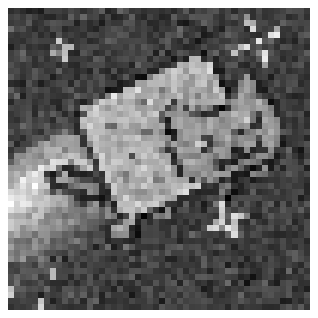

In [363]:
fig = plt.figure(figsize=(15, 5), dpi=80)

plt.imshow(recovery,cmap='gray')
plt.grid(False)
plt.axis('off')

fig.savefig('Fig6.pdf', dpi=fig.dpi)
plt.show()